**Перед тем как начать.**

In [ ]:
# %pip install stingray

# !conda install stingray

In [1]:
from epoch_folding import periodic_generator, phase_plot, res_plot, read_data, _sinusoid, folding_plot
import matplotlib.pyplot as plt
import numpy as np

## Откуда начать?

Текст в этом разделе дублирует преподавателя, поэтому рекомендую сначала послушать вводные слова, а затем, при необходимости, вернуться к чтению.

### **Epoch Folding &mdash; это вообще что?**

При анализе в данных выделяют две важные компоненты: сигнал и шум. Их главное отличие в том, что сигнал подчиняется каким-то правилам и имеет какую-то характерную форму во времени, а шум &mdash; это изменения в сигнале, случайно меняющиеся в определенных пределах.

Часто в астрофизике и вообще в науке, работающей со статистикой, уровень сигнала по сравнению с уровнем шума может быть небольшим. Это приводит к тому, что визуально в данных сложно определить наличие, собственно, сигнала.\
Для победы над этим, а также для в целом автоматизированного поиска периода в данных, используется метод наложения эпох или Epoch Folding.

**И где здесь Epoch Folding?**

Epoch Folding или метод наложения эпох -- это один из математически простейших, но от этого не менее эффективных методов исследования временного сигнала.

При временном анализе данных в астрофизике высоких энергий **мы засекаем и отмечаем время попадания на детектор отдельных фотонов**.\
Анализируя этот массив времен, мы можем делать вывод о существовании каких-то особенностей в поведении этих фотонов, например, о существовании периодичности.

Главной идеей метода Epoch Folding является то, что **периодичный сигнал повторяет свою форму через одинаковые интервалы времени**.\
Если **разрезать все время наблюдения на интервалы длиной в период**, то времена прибытия фотонов в каждом таком интервале будут формировать похожую картину. На этой картине будет присутствовать сигнал от нашего наблюдения, который имеет одну и ту же форму, и шум, который случайно заполяет каждый из интервалов.

Если в результате мы **наложим все эти отрезки друг на друга**, то компонента шума будет равномерно размазана по всей длине отрезка, а периодический сигнал будет иметь максимум в одном и том же месте, и накопленный сигнал там будет расти пропорционально числу отрезков.

Таким образом, основная идея, лежащая в основе Epoch Folding &mdash; это усиление сигнала при наложении множества верно найденных периодов друга на друга.

### **Как это применить к настоящим данным?**

Чтобы показать, как работает метод Epoch Folding, рассмотрим простой и совсем искусственный пример, в котором мы будем знать вообще все.

Пусть у нас в руках есть сигнал, который описывается синусоидой с периодом ровно в 3 секунды. Продолжительность сигнала 30 секунд.

Для создания такого сигнала воспользуемся уже написанной функцией `periodic_generator(period, interval_length)`, не разбираясь в том, как она работает.

In [2]:
mean_countrate = 100 # Средняя скорость счета в шт/с
test_period = 3 # Период сигнала
interval_length = 30 # Продолжительность периода
test_interval = np.round(periodic_generator(test_period, interval_length, mean_countrate=mean_countrate), 3) # Генерация сигнала с данными параметрами

Эти данные представляют собой кучу чисел, которые непонятно, как удобно представлять между собой.\
Это подводит нас к обсуждению еще одной важной фундаментальной идеи вообще в анализе данных.

Сейчас мы поговорим о **гистограммах**.

### **Что такое гистограмма?**

Гистограмма &mdash; это особый вид графиков, который разбивает события на группы и рисует число событий в каждой группе.\
В нашем случае вместо того, чтобы отвечать на вопрос «**Когда было зарегистрировано событие?**» мы отвечаем на вопрос «**Сколько событий было зарегистрировано за какой-то интервал времени?**».\
То есть мы разбиваем все время наблюдения на интервалы какой-то продолжительности и просто считаем, сколько фотонов попадает в каждый интервал.

Таким образом мы теряем часть информации о каждом отдельном фотоне, но приобретаем информацию о **распределении фотонов во времени**.

На графике это удобно изображать так:\
По горизонтали мы рисуем столбцы, отражающий отслеживаемый интервал времени, а по вертикали число событий внутри этого интервала.

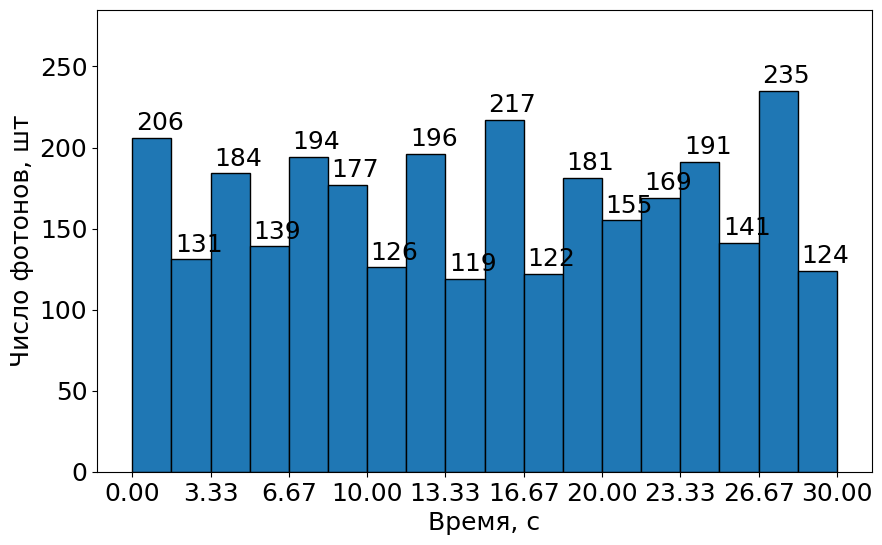

In [3]:
# РАЗБИРАТЬСЯ В КОДЕ НИЖЕ НЕ ОБЯЗАТЕЛЬНО, ЭТО ПРОСТО ПРИМЕР ДЛЯ РИСОВАНИЯ ГРАФИКОВ

plt.figure(figsize=(10, 6))

# Создадим гистограмму по данным times_slice с интервалами записи, разбитыми на 10 областей, выделить края цветом.
hist_data, bin_data, _ = plt.hist(test_interval, bins=18, edgecolor='black') # Запишем информацию о гистограмме в отдельные переменные

# Подпишем над каждым столбиком число зарегистрированных в нем фотонов.
# Пройдемся по элементам только что созданных массивов
for idx in range(len(hist_data)):
    # Нарисуем в нужных координатах нужный текст
    plt.text(bin_data[idx]+0.15, hist_data[idx]+5, f'{hist_data[idx]:.0f}')

# Зададим разметку на оси x числами от 0 до 100 с шагом в 10 (101 взято, чтобы отрисовать 100)
plt.xticks(ticks = np.linspace(0, 30, 10))

# Зададим название оси x
plt.xlabel('Время, с')
# Зададим название оси y
plt.ylabel('Число фотонов, шт')

# Зададим границы оси y так, чтобы в нее красиво попадали числа
plt.ylim(0, hist_data.max()+50)

# Нарисуем то, что получилось
plt.show()

Теперь, чтобы убедиться, что наш генератор работает правильно, нарисуем гистограмму с более мелким шагом по времени и нарисуем ожидаемый профиль сигнала, который мы задали при симуляции.

__*Почему этот сигнал не совпадает с нашим ожиданием на 100%?*__

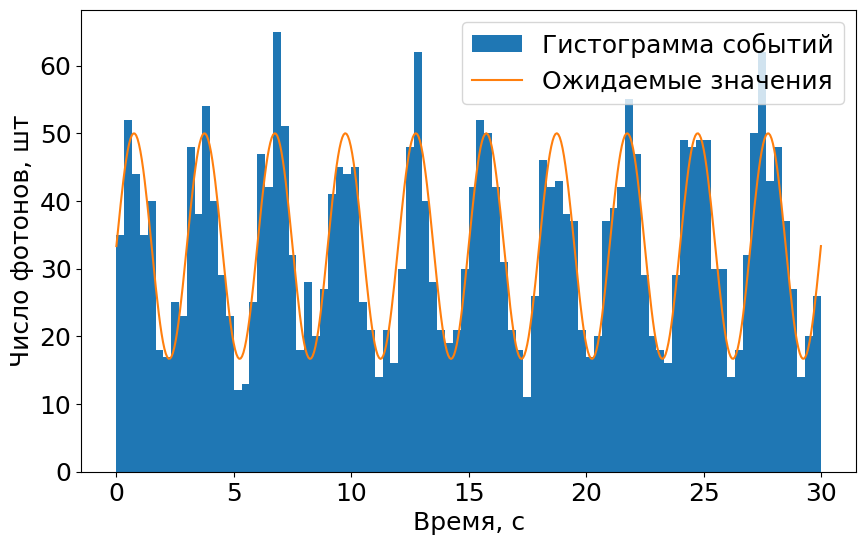

In [4]:
# ЗДЕСЬ СНОВА МНОГО СТРОЧЕК КОДА, КОТОРЫЕ НУЖНЫ ТОЛЬКО ДЛЯ РИСОВАНИЯ
# КРАСИВЫХ ГРАФИКОВ В КОНКРЕТНОМ СЛУЧАЕ. ЭТО НЕ ОТНОСИТСЯ К ДЕЛУ НАПРЯМУЮ,
# ПОЭТОМУ ТУТ МОЖНО ВСЕ ПРОПУСТИТЬ И СПОКОЙНО СМОТРЕТЬ НА КАРТИНКУ.
# ЕСЛИ ВАМ ВСЕ-ТАКИ ИНТЕРЕСНО, К КАЖДОМУ ДЕЙСТВИЮ ДОБАВЛЕНА ПОДПИСЬ.



# Зададим график ожидаемых значений
# t_test - точки по x, где мы вычисляем значения
t_test = np.linspace(0, 30, 500)

# count_test - сами значения ожидаемого числа отсчетов в данной точке.
# _sinusoid - функция для внутреннего пользования для генерации сигнала. 
# Использовать такие функции (со знаком _ в начале) -- плохая практика!
# Здесь это делается исключительно для демонстрации, в настоящей работе
# эта функция не используется сама по себе, только внутри других функций.
count_test = _sinusoid(t_test, 1/test_period, mean_countrate, mean_countrate/2, 0)/3
# на 3 мы делим, чтобы получить то же ожидаемое значение, что и в бинах

plt.close() # Закроем все предыдущие окна с рисунками, если они были
plt.figure(figsize=(10, 6))

# Создадим гистограмму по данным test_interval, которую создали в прошлом блоке
plt.hist(test_interval, bins=90, label='Гистограмма событий')
# Нарисуем график зависимости ожидаемых значений от времени
plt.plot(t_test, count_test, label='Ожидаемые значения')

plt.legend() # Нарисуем легенду графика
plt.xlabel('Время, с') # Зададим название оси x
plt.ylabel('Число фотонов, шт') # Зададим название оси y
plt.show() # Нарисуем то, что получилось

### **Разбираем метод Epoch Folding.**

Выше мы без труда построили описывающую наши данные кривую (потому что знали изначальные параметры).
Но что делать в общем случае, когда мы не знаем периода, и хотим его найти?

Поиск периода при помощи Epoch Folding в том, что мы **предполагаем** определенный период в сигнале, разрезаем массив событий на интервалы продолжительностью в этот период и накладываем друг над друга. Покажем, как это работает на наших только что сгенерированных данных:\
Разделим их на интервалы по 3 секунды и посмотрим, что происходит, если мы наложим их друг на друга.

Сгенерируем графики при помощи функции `folding_plot(time, period)`, которая делает много ужасных вещей для красивых картинок, поэтому это мы не предлагаем посмотреть даже пытливым участникам школы.

Каждый цвет на этом графике относится к одному периоду: синий на интервале от 0 до 3 секунд, оранжевый &mdash; от 3 до 6 секунд и т.д.

Нижний график показывает, что будет, если мы все эти нарезанные по 3 секунды интервалы поставим друг на друга. 

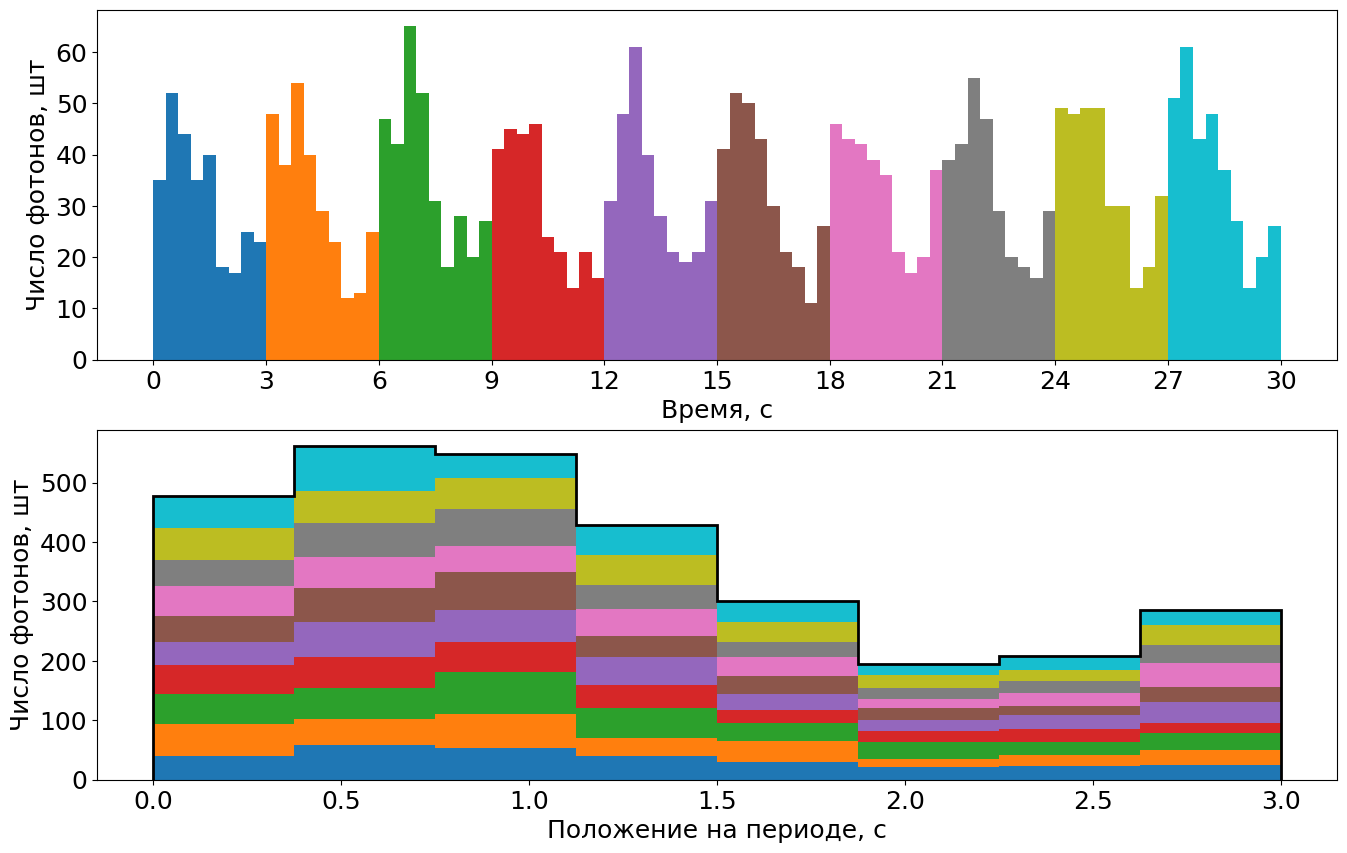

In [5]:
plt.close()
folding_plot(test_interval, 3)
plt.show()

На верхнем графике мы увидели, что периоды выделились хорошо, а на нижней картинке мы даже удалось получить явное распределение фотонов внутри одного периода.

**Почему нам это интересно?**

Дело в том, что такое поведение характерно только в случае, если период определен верно.\
Посмотрим, что случится с графиками, если мы укажем другой период, например, 2 секунды.

При этом наш явно выделенный пик в каждом периоде попадает уже не в одно и то же место нарезанных отрезков, а куда-то в случайное их место.\
В результате то, что мы получаем, совсем не похоже на сигнал, который мы видели выше.

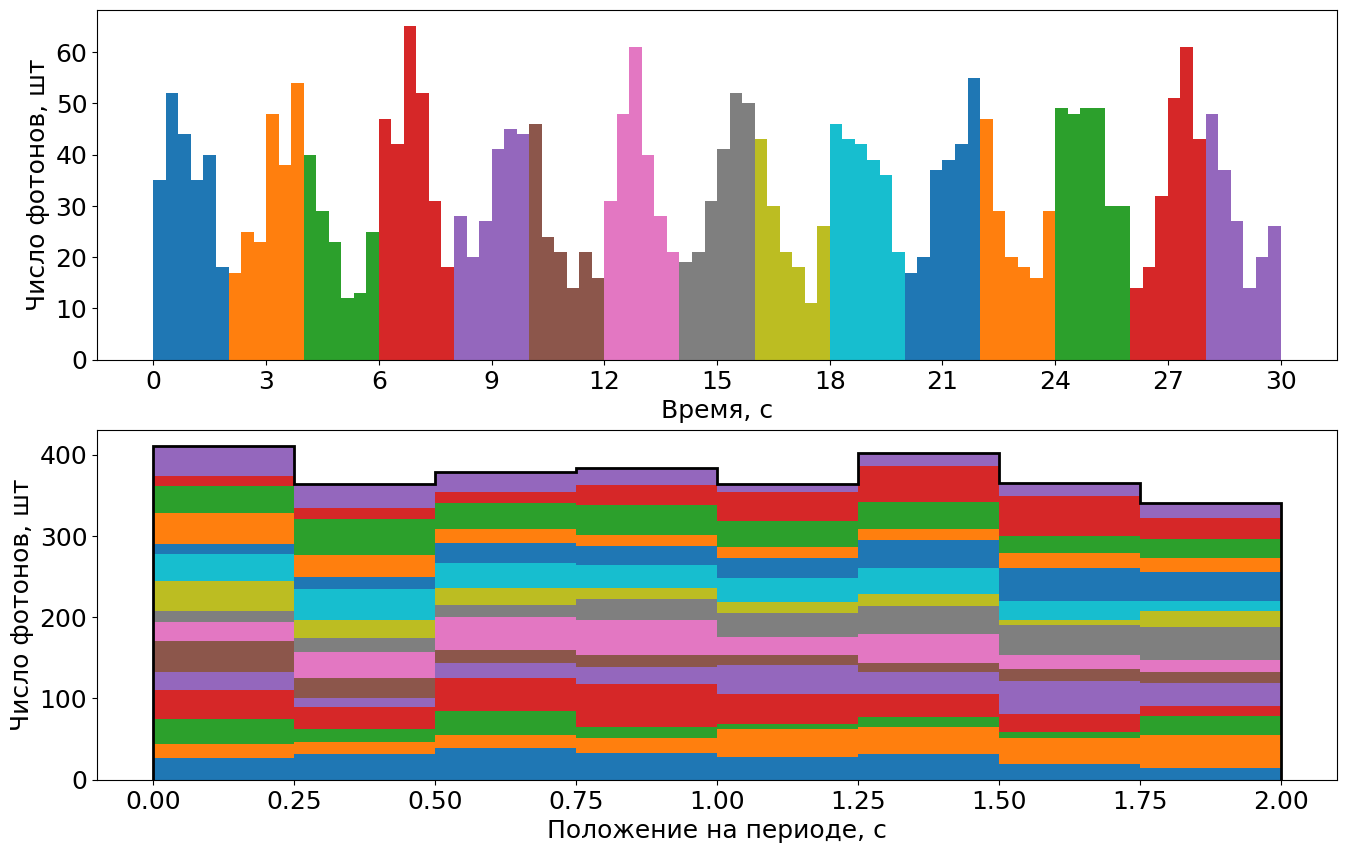

In [6]:
plt.close()
folding_plot(test_interval, 2)
plt.show()

Как мы видим, неправильно подобранный период нарезает наши данные на отрезки, в которых форма сигнала каждый раз отличается, поэтому при наложении создается неструктурированная мешанина, в итоге приводящая к тому, что мы не видим в данных никакой закономерности.

Именно этим свойством мы хотим воспользоваться:\
Когда период определен **верно**, мы увидим явное отличие профиля сигнала (т.е. распределения фотонов по периоду) от плоской линии.\
Когда период определен **неверно**, мы вместо профиля сигнала увидем равномерное заполнение всего периода, то есть почти прямую линию.

Теперь попробуем самостоятельно написать функцию, которая будет делать такой анализ в автоматическом режиме.

## Напишем свой Epoch Folding!

### **Шаг 1. Научимся искать фазы**

Итак, мы разобрались, как это работает на пальцах, но теперь надо написать код, который будет делать тот анализ, который нам нужен.

Начнем с самого важного: определение **фазы** каждого фотона при заданном периоде.

Фаза фотона -- это точка, в которую упадет фотон при нарезании и наложении периодов друг на друга.

Пусть у нас есть время прихода каждого фотона в данных и некий заданный период.

Напишем функцию, которая будет искать, на какую часть периода приходится данный фотон.

**Пример**:
1. У нас есть 5 фотонов, время прибытия которых в секундах записано в массиве:\
[0, 1, 2, 3, 4, 5].

![phase 1](supplementary/phase1.png)

2. Мы хотим найти, какое положение на периоде каждый из них будет занимать, если период равен 4.\
Для этого найдем остаток от деления каждого времени на период 4. В результате мы получим массив:\
[0, 1, 2, 3, 0, 1].\
(Подумайте, почему это то, что нам нужно?)

![phase 2](supplementary/phase2.png)

3. В дальнейшем мы будем работать с одновременно с разными периодами.\
Чтобы сравнивать между время прихода фотона нужно нужно избавиться от информации об аболютном значении периода.\
Для этого мы дополнительно разделим каждое значение на период в 4 секунды.\
В результате получится массив:\
[0, 0.25, 0.50, 0.75, 0, 0.25]

![phase 3](supplementary/phase3.png)

Массив, который мы получили, содержит информацию о **фазе** каждого фотона в предположении периода в 4 секунды.

Попробуем написать функцию `phase_position(time, period)`, которая сделает все эти операции для произвольного массива

In [8]:
def phase_position(time_array: np.array, period_value: float) -> np.array:
    # time_array   -- это массив как в примере выше,
    # period_value -- это значение периода.
    # На выход мы хотим подавать массив такого же размера, что и time_array

    # Нужно для каждого фотона в массиве time_array вычислить
    # фазу этого фотона для заданного периода period_value

    # МЕСТО ДЛЯ ВАШЕГО КОДА
    # ======================

    output_array = (time_array % period_value) / period_value # Это заглушка, ее можно удалить

    # ======================

    return output_array

<p>
<details>
<summary> Кликни здесь, если хочешь узнать ответ. </summary>

``` python
def phase_position(time_array: np.array, period_value: float) -> np.array:
    
    output_array = (time_array % period_value) / period_value
    
    return output_array
```

</details>
</p>

Теперь посмотрим, похоже ли то, что мы получаем, на ранее показанные картинки.

Попробуем нарисовать гистограмму с распределением фотонов по фазе для настоящего периода в наших данных, то есть для 3 секунд.\
Для отрисовки воспользуемся функцией `plt.hist(data, num_bins)`

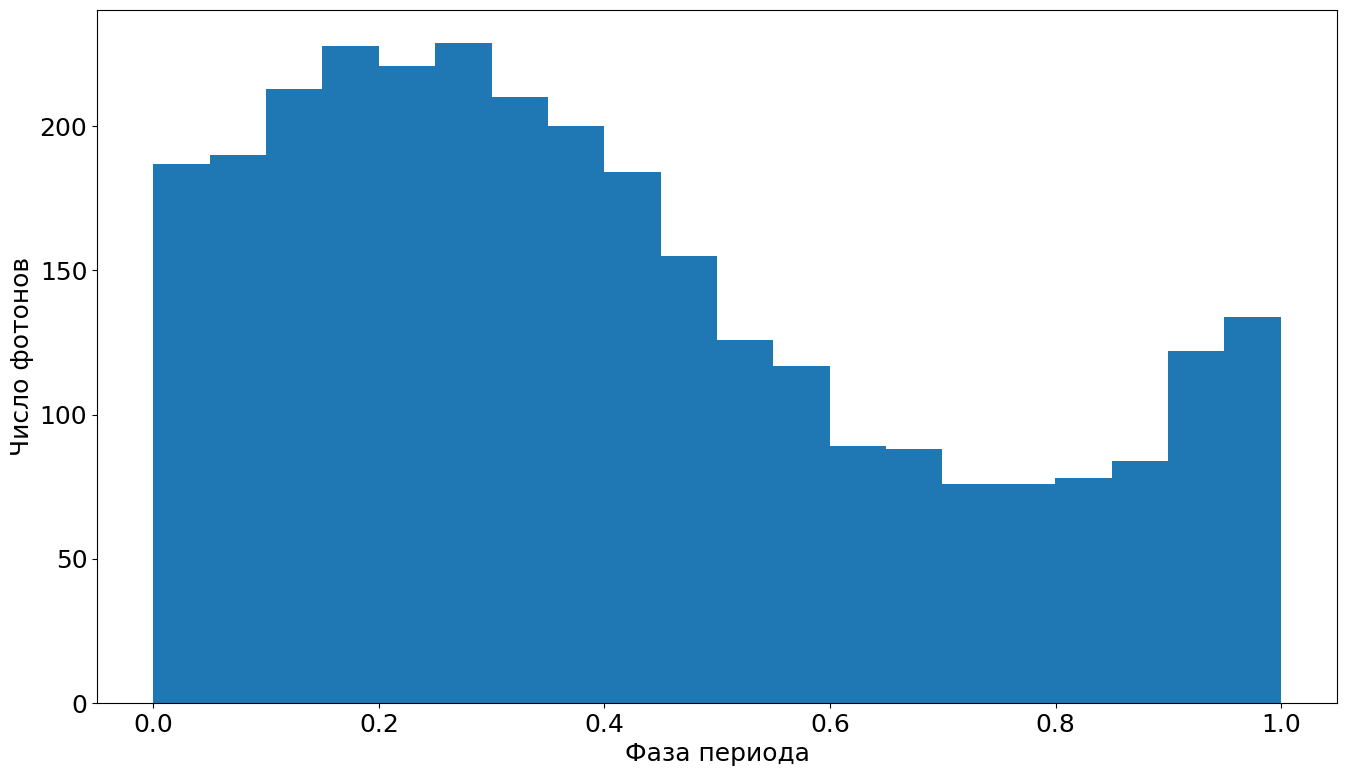

In [9]:
phase_position_good = phase_position(test_interval, period_value=3)

plt.close() # Закроем все прошлые окна, если они есть
plt.hist(phase_position_good, bins=20) # Построим гистограмму фаз.
plt.xlabel('Фаза периода') # Добавим подписи по оси x
plt.ylabel('Число фотонов') # Добавим подписи по оси y
plt.show() # Покажем получившийся график

Если функция написана верно, мы должны увидеть гистограмму в виде синусоиды с пределами по оси x от 0 до 1.

Теперь проделаем то же самое, но с неверным периодом, например, 2 секунды.\
__*Что мы видим?*__

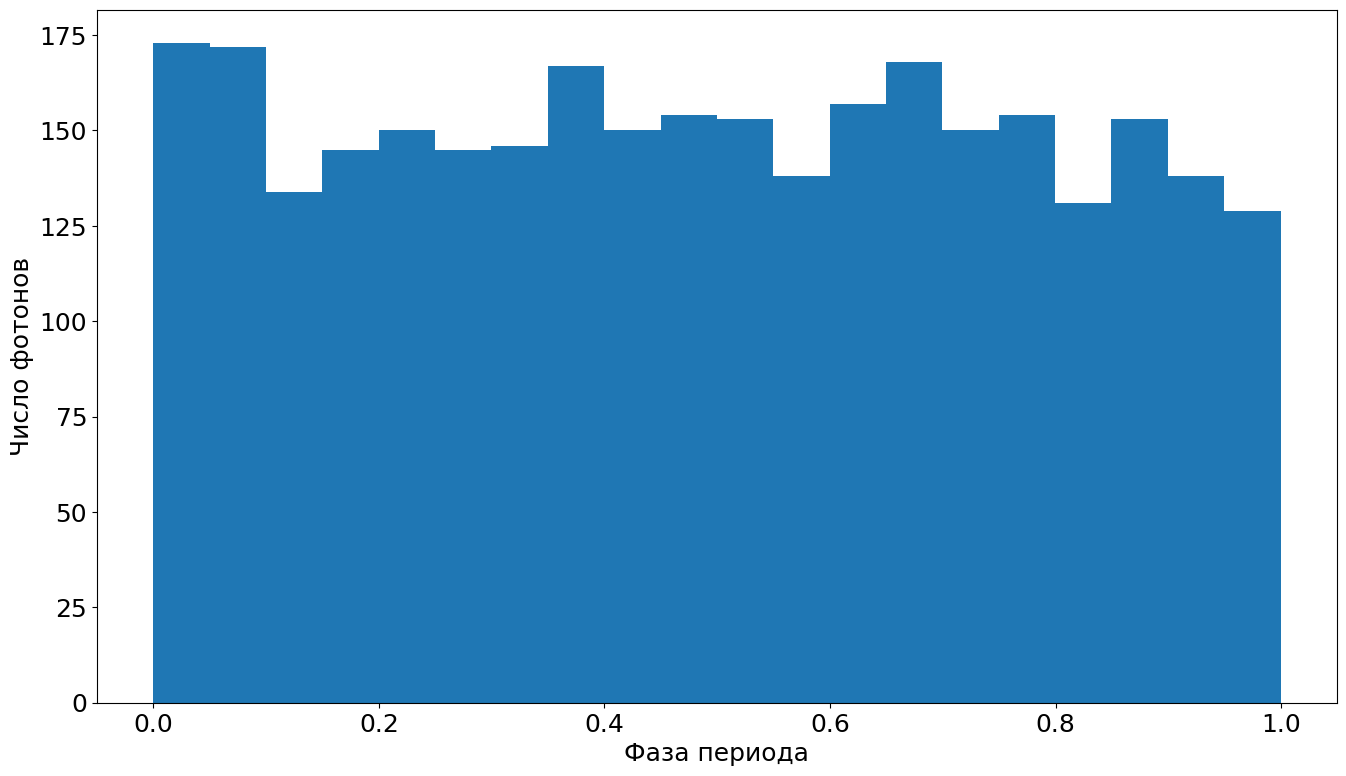

In [10]:
phase_position_bad = phase_position(test_interval, period_value=2)

plt.close()
plt.hist(phase_position_bad, bins=20)
plt.xlabel('Фаза периода')
plt.ylabel('Число фотонов')
plt.show()

Если мы все сделали правильно, то должны были получить гистограммы, которые очень напоминают те, что мы видели на картинках выше.\
При этом мы явно видим, что при периоде в 3 секунды наш сигнал имеет явно не плоский вид, а при неверном периоде в 2 секунды получается плоское заполнение фотонами всех отрезков гистограммы, которое сигнализирует об отсутствии периода.

### **Шаг 2. Тяжелая артиллерия статистики. Научимся считать хи-квадрат.**

Выше мы смогли определить, где есть период, а где нет, на глаз, посмотрев на картинки, но **обычно ситуация обстоит иначе**:
1. Мы не знаем, **где именно находится период**, и должны построить такие гистограммы для сотен и тысяч разных значений периодов.
2. Мы не знаем, как **численно оценить качество сигнала**, насколько сигнал на нашей гистограмме на самом деле отражает какую-то периодичность в сигнале.

Отсматривать глазами 1000 картинок с линейкой в руках мы не намерены, поэтому зададимся вопросом:\
Можно ли придумать какое-то математическое выражение, которое будет отражать наличие явного профиля сигнала численно?

Оказывается, такое выражение существует и очень активно применяется в астрофизике и математической статистике в целом.

Сейчас мы научимся вычислять значение **$\chi^2$, хи-квадрат**, для наших данных.

#### **В чем основная идея хи-квадрат?**

Основная идея хи-квадрат в том, чтобы сравнить между модель и реальные экспериментальные данные, и представить результаты этого сравнения в виде одного числа:\
Чем это ближе значение хи-квадрат к 0, тем лучше модель и данные совпадают между собой.\
Чем дальше значение хи-квадрат от 0, тем больше модель и данные различаются.

Для вычисления значения хи-квадрат нам необходимо:
1. Найти **значения модели и эксперимента в одних и тех же точках**.
2. Вычислить **разницу между точками модели и эксперимента**.
3. Совершить несколько дополнительных преобразований (возвести в квадрат, нормировать на значения модели)
4. **Просуммировать полученные значения во всех точках**.

В результате мы получаем одно число, которое служит **показателем качества совпадения модели и эксперимента**.

![Иллюстрация хи-квадрат](supplementary/chi2_illustration.png)

#### **Какую модель используют в Epoch Folding?**

Когда мы работали с нашими данными и задавали неправильный период, то при наложении периодов получали почти равномерное заполнение фотонами каждого интервала гистограммы.

Это поведение характерно для любых ситуаций, вне зависимости от поведения настоящего периодического сигнала.

Тогда в качестве нашей модели и будем использовать предположение о том, что **все фотоны равномерно заполняют нашу гистограмму**. Это значит, что нашей моделью для гистограммы будем прямая плоская линия.

Если мы подобрали в данных **неправильный период**, то фотоны лягут на гистограмме плоско, как мы видели выше, модель хорошо опишет данные, и значение **хи-квадрат будет маленьким**. (Рисунок слева)

Если же **период подобран верно**, то фотоны будут заполнять гистограмму неравномерно, и наша простая модель будет плохо описывать данные, поэтому **хи-квадрат будет большим**. (Рисунок справа)

![Гистограмма](supplementary/hist_with_model.png)

Теперь попробуем реализовать эту идею в коде.

#### **Простая модель без периодичности** 


Как обсуждалось выше, результат, который мы будем ожидать при наложении данных с неверным периодом для $N_{photons}$ зарегистрированными фотонами на $N_{bins}$ интервалов будет равен\
$E = {N_{photons}}/{N_{bins}}$

Попробуем написать функцию, которая для проивзольного массива time_array и заданного числа интервалов гистограммы num_bins будет возвращать число, равно среднему числу фотонов в каждом интервале гистограммы.

**Пример**:

Мы имеем массив time_array, в котором записано 150 времен регистрации фотонов. Мы хотим сделать epoch_folding и нарисовать гистограмму фаз, разбитую на 20 интервалов.\
В этом случае у нас на каждый интервал в среднем будет приходиться 150 / 20 = 7.5 фотонов, если считать, что все фотоны распределены по фазе равномерно.\
Именно эту величину и надо посчитать в функции `expected(data, num_bins)`.

In [ ]:
def expected(time_array: np.array, num_bins: float = 20) -> float:
    # time_array -- это массив времени регистрации фотонов
    # num_bins   -- это число интервалов, на которые мы будем разбивать профиль периода для сравнения.
    # Сколько интервалов будет на гистограмме мы выбираем сами, обычно в анализе используется 20.

    # МЕСТО ДЛЯ ВАШЕГО КОДА
    # =====================

    expected_value = 0 # Это заглушка, ее можно удалить

    # =====================

    return expected_value

<p>
<details>
<summary> Кликни здесь, если хочешь узнать ответ. </summary>

``` python
def expected(time_array: np.array, num_bins: float = 20) -> float:

    expected_value = len(time_array)/num_bins

    return expected_value
```

</details>
</p>

Нарисуем, как это будет выглядеть на графике вместе с гистограммой с верно определенным периодом.\
Для отрисовки ожидаемого значения используем функцию `plt.hlines()`, которая рисует горизонтальные линии.

In [ ]:
expected_value = expected(test_interval, num_bins=20)

plt.close()
plt.hist(phase_position_good, bins=20, label='Фазовый профиль периода')
plt.hlines(expected_value, 0, 1, colors='tab:orange', label='Ожидаемое значение без периода')
plt.legend()
plt.xlabel('Фаза периода')
plt.ylabel('Число фотонов')
plt.ylim(0, 250)
plt.show()

#### **Вычисление значения хи-квадрат**

Формульно значение хи-квадрат для конкретной модели и данных записывается так:

$\chi^2=\sum_{i=1}^n\cfrac{(O_i-E_i)^2}{E_i}$,\
где $O_i$ - наблюдаемое число событий в $i$-м интервале по фазам, $E_i$ - ожидаемое равномерным распредением число событий на интервал

Для написания функции, вычисляющей хи-квадрат, нужно:
1. Посчитать, сколько фотонов будет в каждом фазовом интервале.
2. Посчитать, какое ожидаемое значение в каждом фазовом интервале в предположении, что никакого периода нет.
3. Найти отклонение реальных данных от ожидаемых.
5. Возвести все в квадрат.
4. Нормировать отклонение на ожидаемое значение.
6. Просуммировать полученные значения для всех фазовых интервалов.

Теперь давайте попробуем встроить все эти шаги в вычисление хи-квадрат для заданных временных данных и заданного периода. 

In [ ]:
def chi_square(time_array: np.array, period_value: float, num_bins=20):
    # time_array   -- это массив времени регистрации фотонов
    # period_value -- это значение периода.
    # num_bins     -- это число интервалов, на которые мы будем разбивать профиль периода для сравнения.

    # МЕСТО ДЛЯ ВАШЕГО КОДА

    # Напоминание!
    # Сначала нужно найти фазу каждого фотона функцией phase_position,
    # а потом шаги из описания выше.
    # =====================
    
    chi_square = 0 # Это заглушка, ее можно удалить

    # =====================

    return chi_square

<p>
<details>
<summary> Кликни здесь, если хочешь узнать ответ. </summary>

``` python
def chi_square(time_array: np.array, period_value: float, num_bins=20) -> float:

    phase_position_array = phase_position(time_array, period)

    histogram_arr = np.histogram(phase_position_array, bins=num_bins)[0]

    expected_value = expected(time_array, num_bins)

    chi_square = np.sum((histogram_arr - expected_value) ** 2/expected_value ** 2)

    return chi_square
```

</details>
</p>

Проверим, как это работает при вычислении хи-квадрат для верного и неверного периодов.

In [ ]:
print('C хорошим значением периода chi_square =', chi_square(test_interval, 3))
print('C плохим значением периода chi_square =', chi_square(test_interval, 2))

Итак, чего мы добились?

Теперь мы можем взять любые временные данные и любой период, и одной функцией получить численное описание того, есть ли такой период в данных, или нет.

### **Шаг 3. Автоматизация!**

Теперь для полноценного анализа нам осталось только автоматизировать проверку разных периодов, и мы получим полноценный инструмент, который будет работать с настоящими научными данными.

Расчет всех численных значений мы и так автоматизировали, там все считается простым использование функции chi_square.

**Что еще можно автоматизировать?**

Для полноценного автоматического поиска нам осталось придумать, как внутри функции выполнять проверки для целого списка различных периодов, а потом просто возвращать результат в виде удобного для просмотра массива.

Напишем функцию search, которая будет считать значение хи-квадрат для множества разных значений периодов в заданных данных. 

In [ ]:
def search(time_array: np.array,
           period_min: float,
           period_max: float,
           num_bins: int = 20,
           num_periods: int = 100):
    # time_array  -- массив времени регистрации фотонов
    # period_min  -- минимальное значение периода, для которого считается хи-квадрат
    # period_max  -- максимальное значение периода, для которого считается хи-квадрат
    # num_bins    -- число интервалов, на которые мы будем разбивать профиль периода для сравнения
    # num_periods -- число периодов, для которых мы посчитаем хи-квадрат через равные интервалы между period_min и period_max
    
    # Создадим массив периодов, для которых считаем хи-квадрат.
    periods = np.linspace(period_min, period_max, num_periods)
    # Создадим пустой массив, куда будем записывать значение хи-квадрат.
    stats = np.zeros(num_periods)

    # Здесь вам нужно самостоятельно написать цикл, который будет записывать значение хи квадрат для периода
    # ======================================================



    # ======================================================
    return periods, stats

Проверим, как наша свежеиспеченная функция справится с тестовыми данными с периодом 3.

In [ ]:
period, stat = search(test_interval, period_min=0.1, period_max=5., num_periods=200)

Для экономии времени и концентрации на результатах мы предлагаем для рисования использовать функции `res_plot()` и `phase_plot()`.

Нарисуем график с результатами применения функции `search` к нашему сгенерированному набору данных `test_interval`. На графике выделяется пик на уровне 3 секунды, что и является периодом, который мы сами задали для этого сгенерированного набора.

In [ ]:
res_plot(period, stat, line=3)

Теперь убедимся, что при периоде в 3 секунды получается красивая фазовая диаграмма, которая совпадает с нашими ожиданиями синусоидального сигнала.

In [ ]:
phase_plot(test_interval, 3)

Теперь на том же графике нарисуем дополнительно профиль сигнала, который получается, если взять неверный период, например, 2 секунды.

Убедимся, что при этом профиль сигнала становится плоским.

In [ ]:
phase_plot(test_interval, 3)
phase_plot(test_interval, 2, add_plot=True)

Таким образом, мы научились работать с временными данными и применять Epoch Folding для их анализа.

Следующим шагом станет проделать все эти непростые манипуляции на специально подготовленных сгенерированных данных, в которых мы надеемся обнаружить ранее неизвестный период.

## Периодичность в данных пульсара (симуляция)

В этой секции мы попробуем применить нашу функцию для Epoch folding для анализа более сложного сигнала.\
Данные, которые мы используем -- это результат симуляции наблюдения, в котором мы видим пульсар со своим малым периодом обращения и каким-то еще периодом, ранее не наблюдавшемся и нехарактерным для такого типа объектов.\
Наша задача состоит в том, чтобы показать две вещи:
1. У сигнала, который мы будем наблюдать, действительно больше 1 периода.
2. Найти оба периода (и после этого озадачить теоретиков своего отдела, чтобы они придумали, откуда эти периоды взялись).

### **Читаем данные.**

Загрузим наши данные для работы и посмотрим на них глазами.\
Сделать это можно с помощью предварительно написанной функции `read_data(link)`.\
read_data принимает строчку с расположением .txt файла, который нужно прочитать.

In [ ]:
times = read_data(r'data/period_search.txt')

Функция, помимо загрузки данных из файла вывела нам заголовок единственного столбца и размерность единиц.\
(Как удобно! Какой молодец тот, кто это придумал!).

Мы заранее знаем, что будем работать с данными о времени, выраженными в секундах.

Посмотрим, что еще можно узнать о данных до непосредственной работы.

In [ ]:
print('Что загрузили  = ', type(times)) # type(x) выдает тип данных переменной x
print('Размер массива = ', times.shape) # У numpy-массивов shape выдает размер массива
print('Что внутри     = ', times.dtype) # У numpy-массивов dtype выдает тип данных внутри массива

Таким образом, в наши данные - это **массив** из **300 000 действительных чисел**, каждое из которых имеет физическое значение времени в секундах.

Это физическое значение:\
**время регистрации** фотона,\
который попал на **наш детектор**\
при наблюдении **космического объекта**\
нашим **рентгеновским телескопом**.

**Как эти данные выглядят на практике?**

Несмотря на глубокий физический смысл, данные, с которыми мы будем работать, представляют собой набор чисел.\
Попробуем вывести 10 первых значений в массиве.

In [ ]:
for idx in range(10):
    # Запишем код, который выведет, что содержится в массиве times под индексом idx.
    # Заодно мимолетом еще раз вспомним, как обращаться к массиву по индексу и функцию print.
    print('time =', times[idx])

Попробуем теперь вывести минимальное и максимальное значение в массиве, чтобы понять, в каком диапазоне времени мы работаем.

Код ниже показывает, что мы работаем с наблюдением суммарной продолжительностью в 10 000 секунд.\
Это время непосредственного наведения обычно называют **экспозицией**.

In [ ]:
# Напишем код, который найдет и нарисует максимальное значение в массиве наших данных.
# Вспомним, как работать с функцией max и функцией print.
print(max(times))

# Напишем код, который найдет и нарисует максимальное значение в массиве наших данных.
# Вспомним, как работать с функцией min и функцией print.
print(min(times))

**Что можно увидеть в наших данных без сложного анализа?**

Лучшим вариантом для изображения больших массивов событий, как мы еще раз убедились, является тип графика «гистограмма».

Рассмотрим данные за первые 100 секунд наблюдения.\
Разобъем наш 100-секундый интервал на 100 областей по 1 секунде и посчитаем, сколько событий в каждой из полученных областей.\
В результате получится гистограмма следующего вида:

In [ ]:
# ЭТОТ КУСОК КОДА МОЖЕТ БЫТЬ НЕ СОВСЕМ ПОНЯТЕН, ЭТО НОРМАЛЬНО.
times_slice = times[times < 100]
# ОН ИСПОЛЬЗУЕТСЯ ДЛЯ БЫСТРОГО ПОИСКА ВСЕХ ФОТОНОВ СО ВРЕМЕНЕМ РЕГИСТРАЦИИ МЕНЬШЕ 100 С.
# В НЕМ РАЗБИРАТЬСЯ НЕОБЯЗАТЕЛЬНО.


plt.close() # Закроем все предыдущие окна с рисунками, если они были
plt.hist(times_slice, bins=100) # Создадим гистограмму по данным times_slice
plt.xlabel('Время, с') # Зададим название оси x
plt.ylabel('Число фотонов, шт') # Зададим название оси y
plt.show() # Нарисуем то, что получилось

Здесь мы уже можем видеть две важные вещи:
1. периодические пики, которые характеризуют, что в сигнале есть периодичность с маленьким значением периода;
2. медленное изменение периода сигнала, из-за которого мы видим, что высота пиков как будто меняется по синусоиде.

Попробуем оценить меньший из периодов «на глаз».\
Для этого просто посчитаем число пиков в данных, а затем разделим все время наблюдения (100 секунд) на это число.

Здесь мы предполагаем, что в каждом периоде сигнала будет один такой яркий пик, то есть число пиков соответствует числу периодов за 100 секунд.\
(Подумайте, всегда ли верно такое предположение?)

In [ ]:
time_interval = 0  # Продолжительность интервала времени
peak_number = 1  # Число пиков на графике

print('Оценка «на глаз» T =', time_interval/peak_number)

### **Ищем маленький период.**

Простым анализом на глаз мы нашли, что в данных есть период в диапазоне 3 - 4 секунды, попробуем уточнить его значение по полному набору фотонов, используя наш замечательный новый метод Epoch Folding.\
(Здесь расчеты немного посложнее, чем раньше, поэтому и времени могут занимать больше, 15-20 секунд -- это вполне ожидаемое время, но если вы ждете уже больше минуты, обратитесь в кому-то из ассистентов или преподавателю).

In [ ]:
period, stat = search(times, 0.1, 5, num_periods=200)

Теперь попробуйте **самостоятельно** определить положение пика в данных, которые мы получили.

Для этого можно задавать значение параметра `line` в функции `res_plot`.\
Тогда функция нарисует вертикальную линию в заданном значении периода (т.е. по оси x).

In [ ]:
period_value = 2  # Поменяйте это число, чтобы передвинуть красную линию и совместить ее с пиком.
res_plot(period, stat, line = period_value)

Посмотрим на сигнал, который мы нашли при периоде, который мы нашли.

In [ ]:
phase_plot(times, period_value)

Для тех, кто хочет проверить себя, внутри скрытого окошка написано значение периода, которое должно у вас получиться.

<p>
<details>
<summary> Кликни здесь, если хочешь узнать ответ. </summary>

Значение периода, который вы должны были найти, составляет **ровно 3,5 секунды**.

</details>
</p>

### **Ищем большой период.**

Что насчет второго периода, который легкой оценкой вычислить не удалось? Попробуем применить Epoch folding в более широком диапазоне.

In [ ]:
period_wide, stat_wide = search(times, 5, 30, num_periods=500)

Найдем значение самого маленького из периодов, найденных в этом диапазоне.

In [ ]:
new_period_value = 5
res_plot(period_wide, stat_wide, line=new_period_value)

Здесь мы нашли целый зоопарк различных периодов, но откуда все они взялись, и имеют ли они на самом деле физическое значение?

Чтобы разобраться в этом попробуем нарисовать фазовую кривую для уже известного периода и для самого маленького из только что найденных перидов.

Для проверки значения этого маленького периода можно посмотреть внутри скрытого окошка.

<p>
<details>
<summary> Кликни здесь, если хочешь узнать ответ. </summary>

Значение самого маленького периода из только что найденных составляет **ровно 7 секунд**.

</details>
</p>

In [ ]:
phase_plot(times, period_value)
phase_plot(times, new_period_value, add_plot=True)

### **Учимся интерпретировать данные.**

Что мы здесь увидели? Выходит, что периоды, которые мы видим с регулярными повторениями на нашем графике, на самом деле кратные доли нашего основного маленького периода. Значит, нам нужно убрать из рассмотрения все периоды, которые точно делятся на значение нашего периода и поискать в наших данных что-то еще.

**Настоятельно рекомендуем перед продолжением проверить, что ваши периоды найдены верно. Если это не так, пожалуйста, обратитесь к преподавателю практики**

In [ ]:
res_plot(period_wide, stat_wide, line = np.arange(new_period_value, 30, period_value)) # Нарисуем привычный нам график
# Нарисуем вертикальные линии с шагом в величину малого периода

Таким образом, мы обнаружили, что на самом конце интервала нашего рассмотрения есть пик, который не кратен основному, а значит, имеет какую-то другую природу.\

Попробуем уточнить его значение, проведя еще раз поиск в более узкой области.

In [ ]:
period, stat = search(times, 27, 29, num_periods=200)

In [ ]:
big_period = 27 # Меняйте это значение, пока не найдете пик, соответствующий новому периоду 
                # (но не тому, который кратен маленькому периоду)
res_plot(period, stat, line = big_period)

Таким образом, благодаря нашему новому методу мы обнаружили период, о существовании которого раньше могли только подозревать.\
Напоследок проверим, как выглядит его фазовая кривая.

Для проверки значения этого периода можно посмотреть внутри скрытого окошка.

<p>
<details>
<summary> Кликни здесь, если хочешь узнать ответ. </summary>

Значение самого маленького периода из только что найденных составляет **28.7 секунд**.

</details>
</p>

In [ ]:
phase_plot(times, big_period)

### **Подводим итоги**

Если мы все сделали правильно, то на кривой наблюдается явно неплоский сигнал, пусть и с относительно небольшой амлпитудой (что объясняет высоту пика по сравнению с пиком на 28 секундах).

Кроме того, мы не видим на фазовой кривой никаких признаков самоповторения, как это было показано выше, значит этот период не имеет к нашему малому периоду непосредственного отношения, и мы обнаружили новый сигнал, природу которого можно пытаться объяснять теоретически!

В этот момент ученые бегут к своим коллегам, показывают полученные результаты и начинают мечтательно продумывать содержание своей новой статьи.
Мы, хоть и не сделали сегодня нового открытия, потому что работали с симулированными данными, но зато научились применять один из важнейших методов временного анализа в рентгеновской астрофизике и в целом любой науки, работающей со статистикой.

На этом мы заканчиваем основную часть нашей практики.\
Всех, кто дошел аж до сюда, поздравляем!\
Те, кто до сюда не дошел, поздравляем немного позже.\
А тем, кому мало и этого, предлагаем самостоятельно провести исследование периода уже в самом настоящем рентгеновском наблюдении в следующей секции.

## **Анализ реальных данных.**

In [ ]:
from epoch_folding import real_data_read, real_data_show

В этом самостоятельном задании мы предлагаем всем желающим попробовать решить следующую задачу:\
вычислить период **реального** объекта: рентгеновского пульсара Центавра X-3\
по **реальным** данным космической рентгеновской обсерватории NuSTAR.

С чем придется работать?\
Мы предлагаем поработать с одним временным интервало одного из наблюдений телескопа NuSTAR, когда в центре его поля зрения находился яркий рентгеновский источник Центавра X-3.

Центавра X-3 -- легендарный источник, в первую очередь потому, что именно он является первым обнаруженным рентгеновским пульсаром.\
Сегодня мы предлагаем вам попробовать повторить подвиг ученых и тоже обнаружить период пульсаций в нашем сигнале. 

В данных телескопа этот источник выглядит следующим образом.\
В центре, внутри красного квадрата, показано положение самого источника, а вокруг него широкие «крылья», созданные инструментальными особенностями телескопа.\
В реальной научной работе можно смоделировать поведение этих «крыльев» и учесть их в анализе, но сегодня мы ограничимся рассмотрением сигнала внутри квадрата.

In [ ]:
real_data_show()

Чтение fits-файла и предварительная очистка данных -- это сам по себе довольно времязатратный и трудоемкий процесс, поэтому мы предлагаем для получения массива данных о времени регистрации фотонов использовать готовую функцию.

In [ ]:
real_times = real_data_read()

plt.close()
plt.hist(real_times, bins=500)
plt.xlabel('Время, с')
plt.ylabel('Число фотонов, шт')
plt.show()

Эти данные представляют собой 3500 секунд наблюдения источника, в которых нужно подтвердить наличие периодического сигнала.\
Желаем удачи в поисках!

Для тех, кто хочет себя проверить, можете узнать период объекта по этим данным в скрытом блоке ниже.

<p>
<details>
<summary> Кликни здесь, если хочешь узнать ответ. </summary>

Значение периода в Центавра X-3 по данным, с которыми мы работает, составляет **4.795 секунд**.\
Помимо этого, из-за того, что фазовый профиль сигнала состоит из двух пиков разной высоты, которые разделены примерно на половину от истинного периода, в данных наблюдается вторичный пик по хи-квадрат с периодом вдвое меньше, то есть при **2.3975 секунд**.

</details>
</p>

In [ ]:
# МЕСТО ДЛЯ ВАШЕГО КОДА

## **Дополнительное задание.**

Если все удалось сделать без проблем, попробуйте самостоятельно изучить еще один реальный\
объект по настоящим рентгеновским данным.

В качестве ответа на это задание нужно представить период пульсара и его название.

Искать название объекта в самом файле не запрещено, но нельзя искать в интернете его период.

Ниже представлена функция, которая использовалась для чтения данных выше:
```python
def real_data_read(link):
    data = fits.getdata(link)
    x = data['X']
    y = data['Y']
    t = data['TIME']

    _filter = np.where((data['GRADE'] >= 0) * (data['GRADE'] <= 26) *
                       (data['PI'] >= 35) * (data['PI'] <= 1935))

    x, y, t = x[_filter], y[_filter], t[_filter]
    xy_filter = np.where((x >= 490) * (x <= 510) *
                         (y >= 490) * (y <= 510))

    t = t[xy_filter]
    t_slice = t[np.logical_and(t < (1.866e8 + 7000.), t > (1.866e8 + 3500.))]

    return t_slice
```
Попробуйте разобраться, что делает каждый из кусков кода в этой функции и реализуйте свою похожую\
для анализа данных, представленных ниже:

In [ ]:
from astropy.io import fits

In [ ]:
data = fits.getdata(r'.\data\Add_task.evt')
data